In [1]:
import pandas as pd
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [2]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [3]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
logins.set_index('login_time', inplace=True)
logins['count']=1
logins.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [5]:
logins_resamples = logins.resample('15Min').count()
logins_resamples.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


Text(0.5, 1.0, 'Logins to Ultimate Technologies website in the first quarter of 1970')

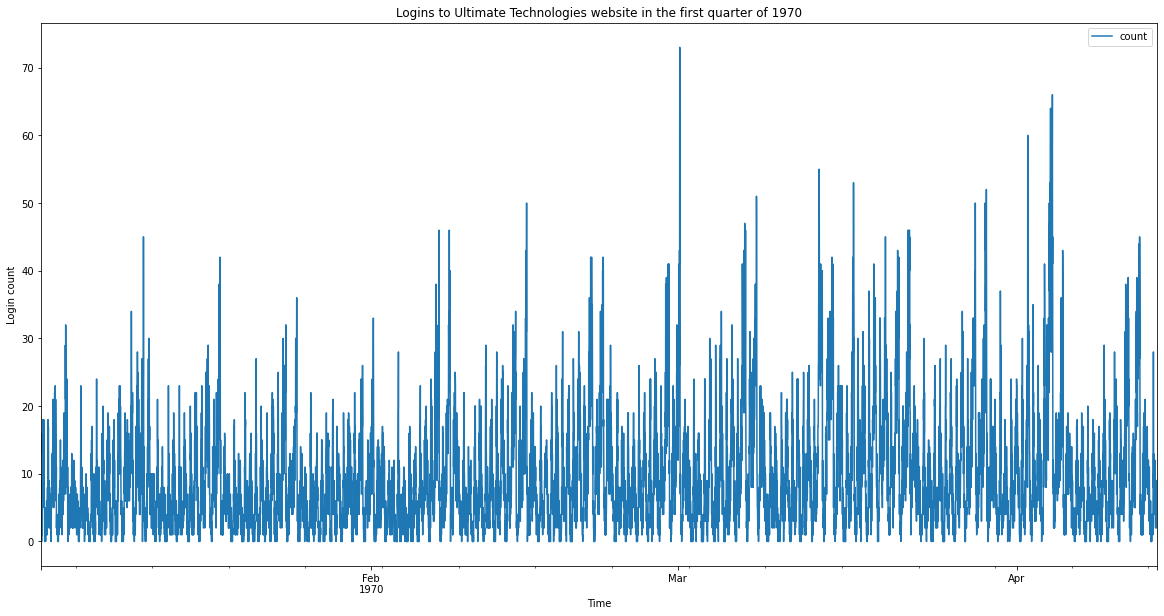

In [8]:
# plot time series
import matplotlib.pyplot as plt
logins_resamples.plot(figsize=(20,10))
plt.xlabel('Time')
plt.ylabel('Login count')
plt.title('Logins to Ultimate Technologies website in the first quarter of 1970')

There appears to be some seasonality. On the first look it is the weekly cycle, perhaps there are more logins on weekdays

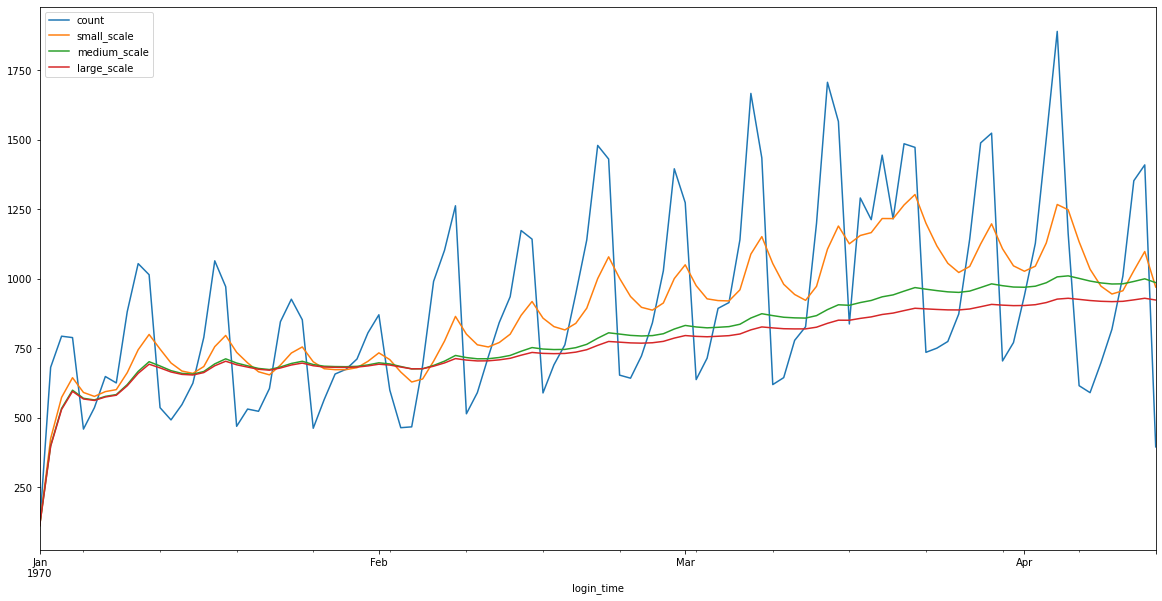

In [99]:
# resample original dataframe by days first
logins_resamples_1d = logins.resample('1D').count()

# Calculate 'small_scale'
logins_resamples_1d['small_scale'] = logins_resamples_1d['count'].ewm(span=10).mean()

# Calculate 'medium_scale'
logins_resamples_1d['medium_scale'] = logins_resamples_1d['count'].ewm(span=100).mean()

# Calculate 'large_scale'
logins_resamples_1d['large_scale'] = logins_resamples_1d['count'].ewm(span=500).mean()

# Plot 'date' on the x-axis and, our three averages and 'count'
# on the y-axis
logins_resamples_1d.reset_index().plot(x='login_time', y=['count', 'small_scale', 'medium_scale', 'large_scale'], figsize=(20,10))
plt.show()

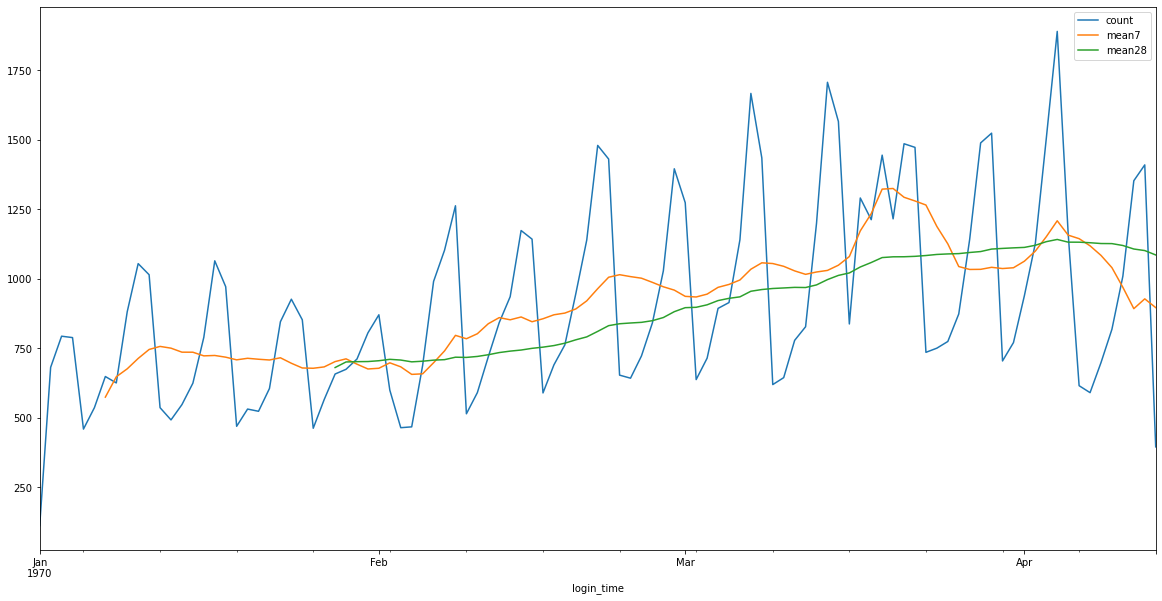

In [100]:
# Calculate 7 day rolling average
logins_resamples_1d['mean7'] = logins_resamples_1d['count'].rolling(window=7).mean()

# Calculate 28 day rolling average
logins_resamples_1d['mean28'] = logins_resamples_1d['count'].rolling(window=28).mean()

# Plot 'date' on the x-axis and, our two averages and 'count'
# on the y-axis
logins_resamples_1d.reset_index().plot(x='login_time', y=['count', 'mean7', 'mean28'], figsize=(20,10))
plt.show()

The rolling and exponential averages reveal the larger scale trend - gradual increase until April and flattening.

In [15]:
# crerate day of the week column
logins_resamples['day_of_week'] = logins_resamples.index.to_series().dt.dayofweek
logins_resamples.head()

,count,day_of_week
login_time,,
1970-01-01 20:00:00,2,3
1970-01-01 20:15:00,6,3
1970-01-01 20:30:00,9,3
1970-01-01 20:45:00,7,3
1970-01-01 21:00:00,1,3


Text(0.5, 1.0, 'Logins by day of the week')

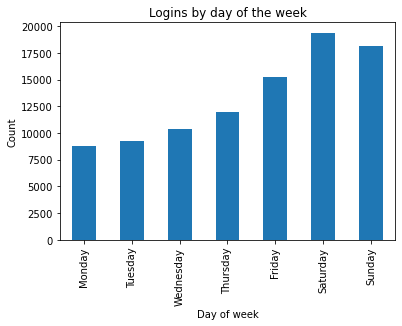

In [27]:
# aggregate by day of the week and plot barchart
%matplotlib inline
logins_resamples.groupby('day_of_week')['count'].sum().plot(kind='bar')
plt.xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);
plt.xlabel('Day of week')
plt.ylabel('Count')
plt.title('Logins by day of the week')

It looks like the weekend is the more active time. The traffic picks up on Thursday and slows down on Monday. Let's see if this is true for all months.

In [28]:
# crerate month column
logins_resamples['month'] = logins_resamples.index.to_series().dt.month
logins_resamples.head()

,count,day_of_week,month
login_time,,,
1970-01-01 20:00:00,2,3,1
1970-01-01 20:15:00,6,3,1
1970-01-01 20:30:00,9,3,1
1970-01-01 20:45:00,7,3,1
1970-01-01 21:00:00,1,3,1


Text(0.5, 1.0, 'Logins by day of the week for each month')

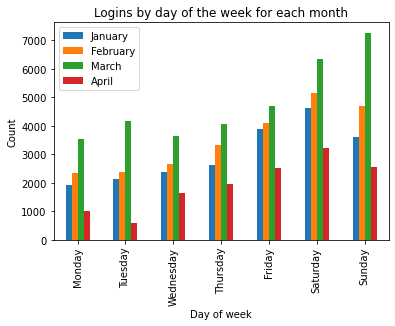

In [38]:
month_week_group = logins_resamples.groupby(['month', 'day_of_week'])['count'].sum()
month_week_group = month_week_group.unstack(level=0)
month_week_group.columns = ['January', 'February', 'March', 'April']
month_week_group.plot(kind='bar')
plt.xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);
plt.xlabel('Day of week')
plt.ylabel('Count')
plt.title('Logins by day of the week for each month')

The trend generally holds true. April data is up to the 13th, which would explain why the bars are lower. So there seams to be 2 trends: weekends are busier and maybe business get busier overall as weather warms. To see if the increased demand holds in april let's look at average and standard deviation of day of the week for each month.

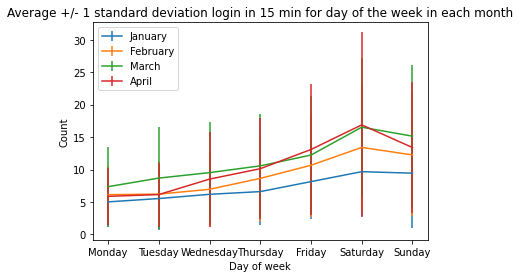

In [55]:
month_week_ave = logins_resamples.groupby(['month', 'day_of_week'])['count'].mean()
month_week_std = logins_resamples.groupby(['month', 'day_of_week'])['count'].std()
month_week_ave = month_week_ave.unstack(level=0)
month_week_ave.columns = ['January', 'February', 'March', 'April']
month_week_std = month_week_std.unstack(level=0)
month_week_std.columns = ['January', 'February', 'March', 'April']
#month_week_ave.plot(kind='bar')
plt.errorbar(month_week_ave.index, month_week_ave['January'], yerr=month_week_std['January'], label='January')
plt.errorbar(month_week_ave.index, month_week_ave['February'], yerr=month_week_std['February'], label='February')
plt.errorbar(month_week_ave.index, month_week_ave['March'], yerr=month_week_std['March'], label='March')
plt.errorbar(month_week_ave.index, month_week_ave['April'], yerr=month_week_std['April'], label='April')
plt.xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);
plt.xlabel('Day of week')
plt.ylabel('Count')
plt.title('Average +/- 1 standard deviation login in 15 min for day of the week in each month')
plt.legend(loc='upper left')

On average April logins match March logins. There appears to have been an increase in average logins from January to February to March. April is holding on the same level as March so far. There also appears to be a large variation in 15 min logins, presumably because of  daily cycles. Let's look at it next.

In [42]:
month_week_ave

,January,February,March,April
day_of_week,,,,
0,5.015625,6.132812,7.358333,5.872093
1,5.531250,6.213542,8.683333,6.145833
2,6.184896,6.953125,9.523438,8.526042
3,6.600000,8.638021,10.567708,10.130208
4,8.139583,10.656250,12.229167,13.088542
5,9.670833,13.408854,16.523438,16.880208
6,9.440104,12.250000,15.139583,13.390625


In [56]:
# crerate hour column
logins_resamples['hour'] = logins_resamples.index.to_series().dt.hour
logins_resamples.head()

,count,day_of_week,month,hour
login_time,,,,
1970-01-01 20:00:00,2,3,1,20
1970-01-01 20:15:00,6,3,1,20
1970-01-01 20:30:00,9,3,1,20
1970-01-01 20:45:00,7,3,1,20
1970-01-01 21:00:00,1,3,1,21


Text(0.5, 1.0, 'Total number of logins by hour')

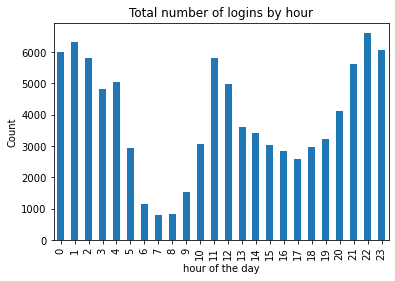

In [57]:
logins_resamples.groupby('hour')['count'].sum().plot(kind='bar')
plt.xlabel('hour of the day')
plt.ylabel('Count')
plt.title('Total number of logins by hour')

Text(0.5, 1.0, 'Average number of logins in 15 min window by hour')

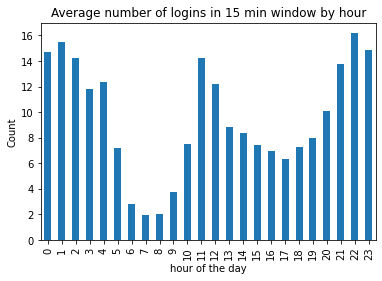

In [58]:
logins_resamples.groupby('hour')['count'].mean().plot(kind='bar')
plt.xlabel('hour of the day')
plt.ylabel('Count')
plt.title('Average number of logins in 15 min window by hour')

The traffic is at the peak 12-2am, 11am, 9-11pm. Since there is no obvious explanation for those specific hours,  most likely the logins took place from different geographic regions with different timezones. Let's see if the average 15 min login count has changed over time.

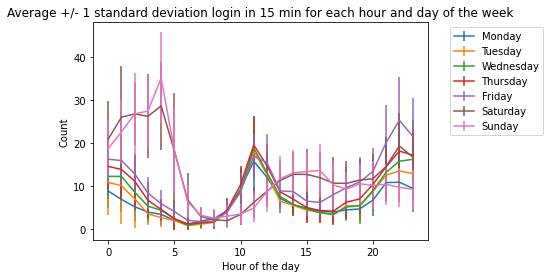

In [61]:
week_hour_ave = logins_resamples.groupby(['day_of_week','hour'])['count'].mean()
week_hour_std = logins_resamples.groupby(['day_of_week','hour'])['count'].std()
week_hour_ave = week_hour_ave.unstack(level=0)
week_hour_ave.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week_hour_std = week_hour_std.unstack(level=0)
week_hour_std.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
def plot_week_hour(day):
    plt.errorbar(week_hour_ave.index, week_hour_ave[day], yerr=week_hour_std[day], label=day)
    
for day in week_hour_ave.columns:
    plot_week_hour(day)
    
plt.xlabel('Hour of the day')
plt.ylabel('Count')
plt.title('Average +/- 1 standard deviation login in 15 min for each hour and day of the week')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Interesting, on weekends there is lot more traffic from midnight to 5am, then it slows down and slowly picks up from 10 to 3pm and stays essentially the same. On weekdays the peak is at 11am, then it slows down and starts picking up 8pm until it peaks at 11pm. 11pm is the busiest for Friday. 1-4am is the busiest time for Saturday and Sunday. All weekdays peak at 11am and 11pm.

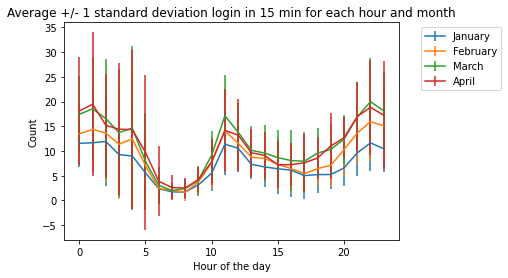

In [63]:
month_hour_ave = logins_resamples.groupby(['month', 'hour'])['count'].mean()
month_hour_std = logins_resamples.groupby(['month', 'hour'])['count'].std()
month_hour_ave = month_hour_ave.unstack(level=0)
month_hour_ave.columns = ['January', 'February', 'March', 'April']
month_hour_std = month_hour_std.unstack(level=0)
month_hour_std.columns = ['January', 'February', 'March', 'April']

def plot_month_hour(month):
    plt.errorbar(month_hour_ave.index, month_hour_ave[month], yerr=month_hour_std[month], label=month)
    
for month in month_hour_ave.columns:
    plot_month_hour(month)
    
plt.xlabel('Hour of the day')
plt.ylabel('Count')
plt.title('Average +/- 1 standard deviation login in 15 min for each hour and month')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

OK, so the only thing that has remained constant is the slow time from 6-10am. For other times we see increase from January to February and from February to March. April appears the same as March. The daily patterns of logins have not changed. Let's see if there is a difference in the beginning middle and end of the month.

In [64]:
# crerate day column
logins_resamples['day'] = logins_resamples.index.to_series().dt.day
logins_resamples.head()

,count,day_of_week,month,hour,day
login_time,,,,,
1970-01-01 20:00:00,2,3,1,20,1
1970-01-01 20:15:00,6,3,1,20,1
1970-01-01 20:30:00,9,3,1,20,1
1970-01-01 20:45:00,7,3,1,20,1
1970-01-01 21:00:00,1,3,1,21,1


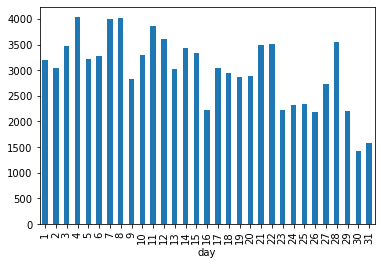

In [66]:
logins_resamples.groupby('day')['count'].sum().plot(kind='bar')

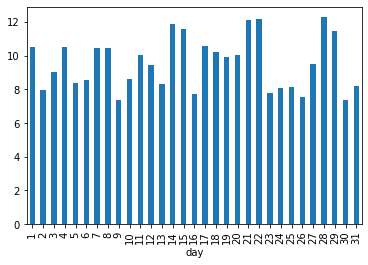

In [67]:
logins_resamples.groupby('day')['count'].mean().plot(kind='bar')

from the count sum it looked as though the counts were going down at the end of the month, but since we only have half of april, a reduction is expected. The average graph shows some some fluctuation but no apparent trend in demand change.

In [68]:
logins_resamples.describe()

,count,day_of_week,month,hour,day
count,9788.000000,9788.000000,9788.000000,9788.000000,9788.000000
mean,9.515938,3.035554,2.259093,11.496935,14.569268
std,8.328818,2.012722,1.017219,6.922294,8.683342
min,0.000000,0.000000,1.000000,0.000000,1.000000
25%,3.000000,1.000000,1.000000,5.000000,7.000000
50%,7.000000,3.000000,2.000000,11.000000,14.000000
75%,13.000000,5.000000,3.000000,17.000000,22.000000
max,73.000000,6.000000,4.000000,23.000000,31.000000


In [70]:
logins_resamples[logins_resamples['count']==0].groupby('day_of_week')['count'].count()

day_of_week
0    70
1    91
2    68
3    79
4    44
5    33
6    22
Name: count, dtype: int64

In [71]:
logins_resamples[logins_resamples['count']==0].groupby('month')['count'].count()

month
1    139
2    126
3    106
4     36
Name: count, dtype: int64

In [72]:
logins_resamples[logins_resamples['count']==0].groupby('hour')['count'].count()

hour
2       4
3       6
4      13
5      50
6     107
7      66
8      79
9      25
10      7
11      2
15      9
16      9
17     13
18      5
19      8
20      2
21      1
22      1
Name: count, dtype: int64

In [73]:
logins_resamples[logins_resamples['count']==0].groupby('day')['count'].count()

day
1     10
2     16
3     23
4     15
5     17
6     17
7     16
8     18
9     19
10    16
11    13
12    12
13    18
14     8
15     9
16    17
17    12
18    10
19    18
20    12
21    14
22     7
23    10
24    11
25    17
26    13
27    14
28     7
29     6
30     6
31     6
Name: count, dtype: int64

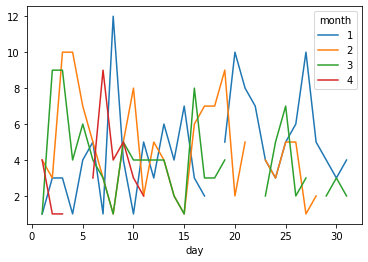

In [79]:
logins_resamples[logins_resamples['count']==0].groupby(['month', 'day'])['count'].count().unstack(level=0).plot()

The gas in time series (0 counts) appear distributed thrhoughout, there are no cluseters.

In [80]:
logins_resamples['count'].max()

73

In [81]:
logins_resamples[logins_resamples['count']==73]

,count,day_of_week,month,hour,day
login_time,,,,,
1970-03-01 04:30:00,73,6,3,4,1


In [82]:
logins_resamples['count'].mean()

9.51593788312219

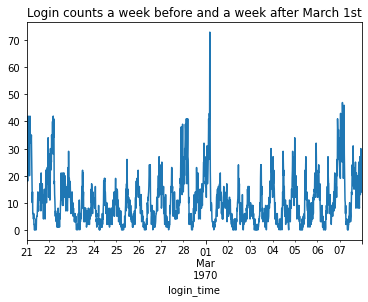

In [90]:
logins_resamples[((logins_resamples['month']==3) & (logins_resamples['day']<=7)) | ((logins_resamples['month']==2) & (logins_resamples['day']>=21))]['count'].plot()
plt.title('Login counts a week before and a week after March 1st');

There is a peculiar spike on March 1st. Either an important event took place or the data is erroneos.

# EDA summary
There appears to be 3 types of seasonality effects:
1. The daily cycle: the demand is at the peak at midnight, next it gradually slows down untill it reaches a minimum 6-8am, next the demand climbs until it peaks again at 11am. From 11am to midnight there is again a gradual decrease and an increase, but the minimum is higher than 6-8am.
2. The weekly cycle: Monday-Thursday are slower and from Thursday starts getting busy untill the demand peaks on Saturday and is somewhat lower on Sunday.
3. Monthly effect: There appears to be an increase in demand from January to February and form February to March. But as much of April as is available (half a month) shows similar demand to March.

Other observations of note:
4. The hourly demand also depends on the day of the week and although the pattern is similar to weekday, the weekend has the highest demand 12-4am.
5. On March 1st there was a spike in logins. This is either a major event or data collection error.
6. There are some time windows that completely lack logins. These are evenly distributed among days, hours and weeks, so it is unlikely to be logging error. But it is something to doublecheck.